# Introduction

**Background**

Histopathology is the study of tissue disease through microscopic examination of tissue samples. It plays a crucial role in the diagnosis and treatment of various diseases, including cancer. One of the most challenging and time-consuming tasks for pathologists is the identification of metastatic cancer in histopathological images. Accurate and timely detection of cancerous cells can significantly improve patient outcomes and treatment strategies.

**Problem Statement**

The Histopathological Cancer Detection competition on Kaggle (https://www.kaggle.com/competitions/histopathologic-cancer-detection)

aims to leverage machine learning and deep learning techniques to automate the detection of metastatic cancer in histopathological images. The dataset provided consists of high-resolution images of lymph node sections, which are labeled as either containing metastatic tissue or not. The goal is to build a model that can accurately classify these images.

**Objective**

The primary objective of this assignment is to develop a  Convolutional Neural Network (CNN) model that can accurately classify histopathological images as either cancerous or non-cancerous. This involves several key steps, including data preprocessing, model building, hyperparameter tuning, and evaluation. By the end of this assignment, we aim to achieve a high level of accuracy in detecting metastatic cancer, thereby demonstrating the potential of deep learning in image analysis.

# Importing the Data

In this section, we'll focus on efficiently importing the dataset required for our analysis directly into the Colab environment. For tabular data, I usually download it to my computer than manually upload into the environment I am working in. I this case however, the data is enormous and a manual approach was cumbersome. Rather than manually downloading the data to a local machine and then uploading it to Colab, we'll leverage the Kaggle API to streamline the process.

We'll begin by installing the necessary libraries and configuring the Kaggle API credentials. Then, we'll use the API to download the dataset directly into Colab. Finally, we'll extract the relevant files and prepare them for further analysis.

In [9]:
!pip install -q kaggle
!pip install -q zipfile36

In [10]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rea613","key":"82712c7598b07d39527ebfbf2f678095"}'}

In [11]:
import os
import zipfile

# Make a directory for the Kaggle API credentials
os.makedirs('/root/.kaggle/', exist_ok=True)

# Move the kaggle.json file to the directory
!mv kaggle.json /root/.kaggle/

# Set permissions for the kaggle.json file
!chmod 600 /root/.kaggle/kaggle.json

In [12]:
# Download the dataset
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.30G/6.31G [01:31<00:00, 113MB/s]
100% 6.31G/6.31G [01:31<00:00, 74.3MB/s]


In [13]:
# Unzip the main competition file
with zipfile.ZipFile('histopathologic-cancer-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('histopathologic-cancer-detection')

# Change directory to the extracted folder
os.chdir('histopathologic-cancer-detection')

# List the files to see what we have
!ls

sample_submission.csv  test  train  train_labels.csv


In [14]:
import pandas as pd
import numpy as np
train_labels = pd.read_csv('/content/histopathologic-cancer-detection/train_labels.csv')
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


# Exploratory Data Analysis

In [15]:
# Change the current working directory to the test folder
os.chdir('/content/histopathologic-cancer-detection/train')

# Get a list of all files in the directory
all_files = os.listdir()

# Create a list of paths to the tif files
tif_paths = [os.path.join('/content/histopathologic-cancer-detection/train', file) for file in all_files]

# Create a pandas DataFrame from the list of paths
df = pd.DataFrame({'path': tif_paths})

# Display the first few rows of the DataFrame
df.head()

,path
0,/content/histopathologic-cancer-detection/trai...
1,/content/histopathologic-cancer-detection/trai...
2,/content/histopathologic-cancer-detection/trai...
3,/content/histopathologic-cancer-detection/trai...
4,/content/histopathologic-cancer-detection/trai...


In [16]:
## Extract 'id' from the 'path' column
df['id'] = df['path'].apply(lambda x: x.split('/')[-1].split('.')[0])

# Perform the join
merged_df = df.merge(train_labels, on='id', how='inner')
merged_df.head()

,path,id,label
0,/content/histopathologic-cancer-detection/trai...,6aff7c7d181e8f3aabdcbd1d9e37e30a3e5b2e44,1
1,/content/histopathologic-cancer-detection/trai...,226f3d61533ce68d1e60c473b5afb65a7e3b009a,1
2,/content/histopathologic-cancer-detection/trai...,ca3ff19cafec40733150d133ece2520dc931fa1d,0
3,/content/histopathologic-cancer-detection/trai...,db390702ef4950614e153d5c0611918ca28d0ddc,0
4,/content/histopathologic-cancer-detection/trai...,7dce7e9c00b8088cbc231f47e97963fb117ae3f5,1


## Check for duplicates and remove if applicable

In [17]:
# Check for duplicates in the 'id' column
duplicates = merged_df['id'].duplicated()

# Count the number of duplicates
num_duplicates = duplicates.sum()

print(f"Number of duplicate IDs: {num_duplicates}")

Number of duplicate IDs: 0


## Class Label Distribution

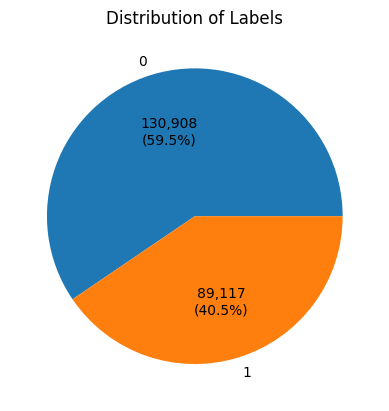

In [18]:
import matplotlib.pyplot as plt

# Count the occurrences of each label
label_counts = merged_df['label'].value_counts()

# Create the pie chart
plt.pie(label_counts, labels=label_counts.index, autopct=lambda p: '{:,.0f}\n({:.1f}%)'.format(p * sum(label_counts) / 100, p))
plt.title('Distribution of Labels')
plt.show()

Let's get a look at some of the pictures to see if we can get some insight

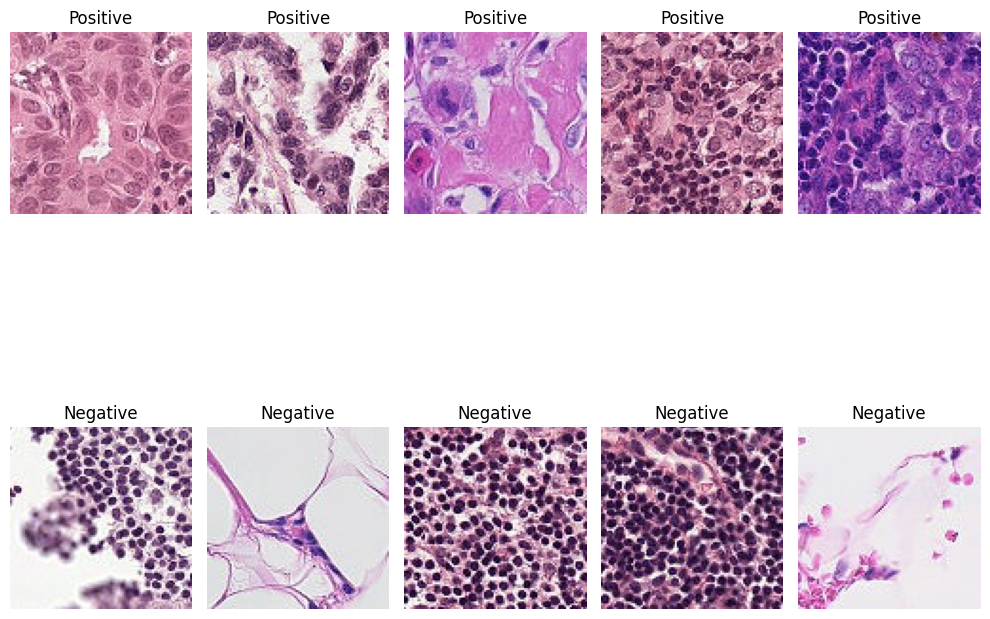

In [19]:
from PIL import Image

# Filter the DataFrame for positive and negative examples
positive_samples = merged_df[merged_df['label'] == 1].sample(5)
negative_samples = merged_df[merged_df['label'] == 0].sample(5)

# Create a 2x2 plot
fig, axes = plt.subplots(2, 5, figsize=(10, 10))

# Display the images
for i, row in enumerate(positive_samples.itertuples()):
    img = Image.open(row.path)
    axes[0, i].imshow(img)
    axes[0, i].set_title('Positive')
    axes[0, i].axis('off')

for i, row in enumerate(negative_samples.itertuples()):
    img = Image.open(row.path)
    axes[1, i].imshow(img)
    axes[1, i].set_title('Negative')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

The pictures look the same to me. I cannot discern any obvious differences between cancerous and benign samples. Let's see if our model can help us make predictions.

Because this is picture data, Our EDA was limited. We looked at the class distribution and checked the data for duplicates, which there were none of. Now, let's move on to building a model

Since the dataset is so large, we need to do a subsample, otherwise we will not have sufficient computing power to train the model. Let's try taking a subsample of 5,000 pictures

# Model Building

In [22]:
from sklearn.model_selection import train_test_split
# Calculate the proportion of positive labels
positive_proportion = merged_df['label'].mean()
display(positive_proportion)

# Stratified sampling to maintain label proportion
_, sampled_df = train_test_split(merged_df, test_size=5000/len(merged_df), stratify=merged_df['label'], random_state=42)

# Verify the proportion in the sampled DataFrame
print(sampled_df['label'].mean())

0.40503124644926713

0.405


 We need to efficiently load and preprocess images in batches during model training. This is crucial when dealing with large datasets that can't fit entirely into memory.

**How it Works:**

The flow_from_dataframe method in the following code internally iterates through the DataFrame, loads images from the specified paths, resizes them to the target size, applies any preprocessing defined in train_datagen (e.g., rescaling, augmentation), and groups them into batches.

It yields batches of image data (i.e 3d matrices of 96x96x3. they are 3d because there is a separate 2d matrix for each R,G and B value of each pixel)  and corresponding labels that we will be using to train the Keras model using the fit() method.

In [23]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Split the data
train_df, val_df = train_test_split(sampled_df, test_size=0.2, random_state=0)

# Set up image data generators
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

# Convert labels from numeric to string
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='.',  # Assuming images are in the current directory
    x_col='path',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary')

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='.',
    x_col='path',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary')

Found 4000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


There are literally an infinity of architectures to choose from, but we will start with a simple CNN model that incorporates the common elements of **convolutional laters** to extract features at increasing layers of abstraction, **pooling layers** to reduce dimensionality and **dense layers** to classify the output.

For a clear overview on the mechanics of CNNs, which shows visually how the different elements of CNN architechture work together, see Josh Starmers excellent video, "Neural Networks Part 8: Image Classification with Convolutional Neural Networks (CNNs)" @ https://www.youtube.com/watch?v=HGwBXDKFk9I

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_df) // 32,  # Number of batches per epoch
    epochs=10,  # Number of epochs to train
    validation_data=val_generator,
    validation_steps=len(val_df) // 32  # Number of batches for validation
)

Epoch 1/10
125/125 [==============================] - 82s 634ms/step - loss: 0.6472 - accuracy: 0.6323 - val_loss: 0.6836 - val_accuracy: 0.6109
Epoch 2/10
125/125 [==============================] - 75s 597ms/step - loss: 0.5525 - accuracy: 0.7325 - val_loss: 0.5195 - val_accuracy: 0.7823
Epoch 3/10
125/125 [==============================] - 77s 613ms/step - loss: 0.5124 - accuracy: 0.7700 - val_loss: 0.6125 - val_accuracy: 0.6905
Epoch 4/10
125/125 [==============================] - 72s 578ms/step - loss: 0.4952 - accuracy: 0.7695 - val_loss: 0.5310 - val_accuracy: 0.7581
Epoch 5/10
125/125 [==============================] - 74s 590ms/step - loss: 0.4891 - accuracy: 0.7747 - val_loss: 0.5375 - val_accuracy: 0.7530
Epoch 6/10
125/125 [==============================] - 77s 612ms/step - loss: 0.4656 - accuracy: 0.7903 - val_loss: 0.5086 - val_accuracy: 0.7752
Epoch 7/10
125/125 [==============================] - 84s 668ms/step - loss: 0.4541 - accuracy: 0.7965 - val_loss: 0.6605 - val_ac

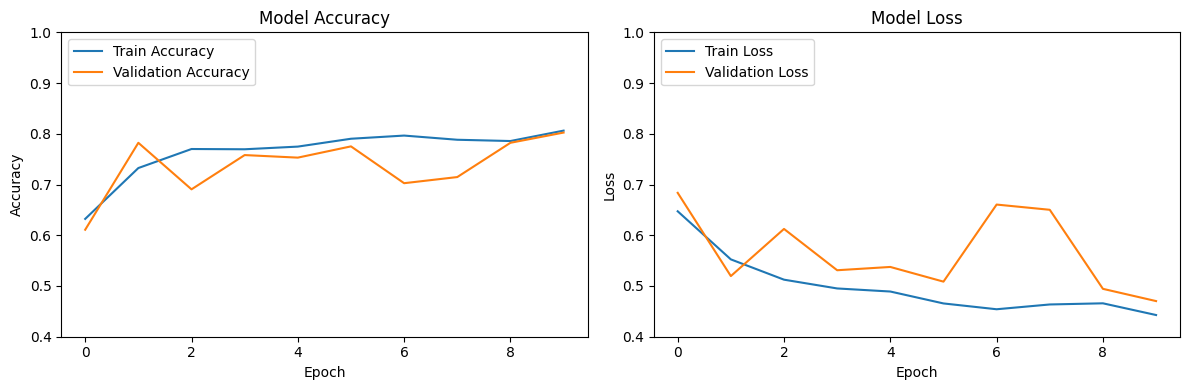

In [25]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.4, 1)  # Set y-axis range from 0 to 1
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.4, 1)  # Set y-axis range from 0 to 1
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

We see that the model stopped improving at around 5 epochs, and that the training metrics were much more stable than the validation metrics

## Hyperparameter Tuning

Next, we will try to improve the model through hyperparameter tuning. We will explore changing the number of filters at each convolution step, as well as the activation function and optimizer. Some brief notes about the hyperparameter tuner algorithm used. In other assignments, I have used grid search or random search. In this one, I will use the Hyperband algorithm. Here is some basic background on how it works:

The Hyperband alogrithm is an efficient hyperparameter optimization algorithm that balances breadth and depth It works by iteratively training multiple models with varying resource allocations (e.g., number of epochs) and eliminating those that perform poorly early on. Better perfoming models are explored further with more epochs

In [26]:
!pip install keras-tuner
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    model.add(Conv2D(
        filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3,3),
        activation=hp.Choice('conv1_activation', values=['relu', 'tanh']),
        input_shape=(96, 96, 3)
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(
        filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3,3),
        activation=hp.Choice('conv2_activation', values=['relu', 'tanh'])
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']),
        loss=hp.Choice('loss', values=['binary_crossentropy']),
        metrics=['accuracy']
    )

    return model
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='intro_to_kt'
)
tuner.search(train_generator, epochs=10, validation_data=val_generator)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)
best_model = tuner.hypermodel.build(best_hps)

Trial 30 Complete [00h 28m 17s]
val_accuracy: 0.7839999794960022

Best val_accuracy So Far: 0.7979999780654907
Total elapsed time: 04h 38m 52s
{'conv1_filters': 32, 'conv1_activation': 'relu', 'conv2_filters': 64, 'conv2_activation': 'relu', 'optimizer': 'adam', 'loss': 'binary_crossentropy', 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0015'}


Now that we have found our best model, we will train it for more epochs to see if it gets better.

Epoch 1/20
125/125 [==============================] - 89s 707ms/step - loss: 0.4529 - accuracy: 0.7935 - val_loss: 0.6027 - val_accuracy: 0.7210
Epoch 2/20
125/125 [==============================] - 90s 724ms/step - loss: 0.4346 - accuracy: 0.8070 - val_loss: 0.5022 - val_accuracy: 0.7710
Epoch 3/20
125/125 [==============================] - 83s 664ms/step - loss: 0.4293 - accuracy: 0.8030 - val_loss: 0.4978 - val_accuracy: 0.7620
Epoch 4/20
125/125 [==============================] - 87s 698ms/step - loss: 0.4205 - accuracy: 0.8098 - val_loss: 0.4515 - val_accuracy: 0.8030
Epoch 5/20
125/125 [==============================] - 78s 623ms/step - loss: 0.4322 - accuracy: 0.8037 - val_loss: 0.5199 - val_accuracy: 0.7490
Epoch 6/20
125/125 [==============================] - 77s 616ms/step - loss: 0.3982 - accuracy: 0.8325 - val_loss: 0.4904 - val_accuracy: 0.7700
Epoch 7/20
125/125 [==============================] - 75s 601ms/step - loss: 0.4110 - accuracy: 0.8200 - val_loss: 0.5592 - val_ac

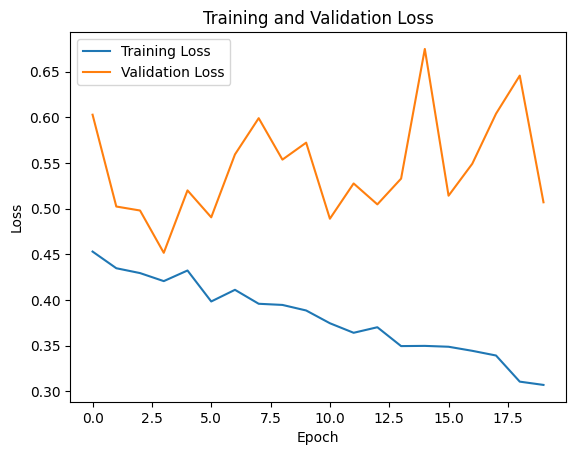

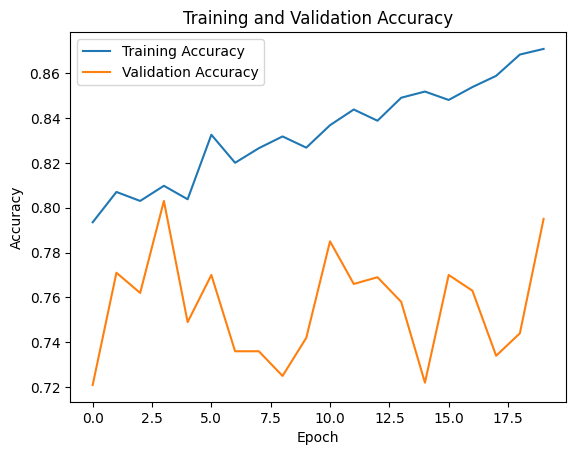

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score

# Train the best model
history = best_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator)



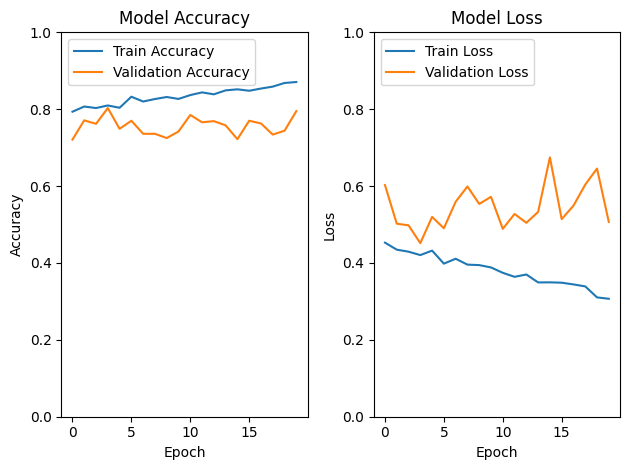

In [34]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis range from 0 to 1
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)  # Set y-axis range from 0 to 1
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

We see that like before, the validation metrics are less stable than the Train metrics. The Train keeps getting better over the epochs, but the Validation fluctuates and does not appear to improve further. As an addendum, lets see how the model did overall when looking at the entire confusion matrix. Our analysis focused on accuracy, but there are other factors to consider in the real world.

32/32 [==============================] - 4s 130ms/step - loss: 0.5068 - accuracy: 0.7950
Test Loss: 0.5068401098251343, Test Accuracy: 0.7950000166893005
32/32 [==============================] - 6s 194ms/step


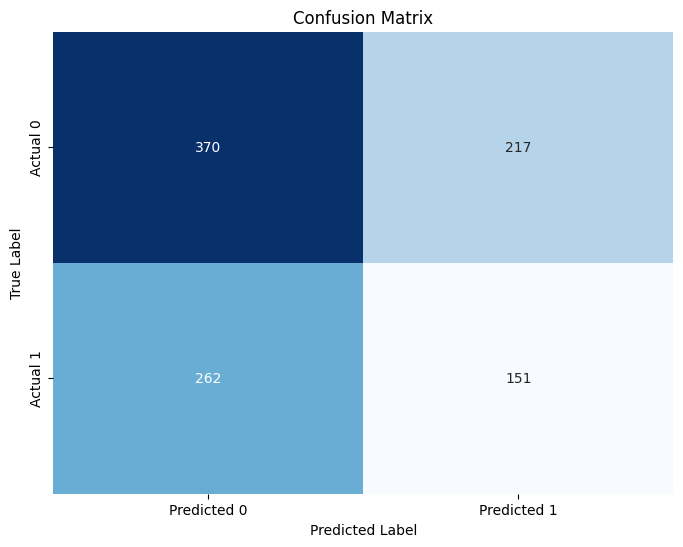

F1 Score: 0.3866837387964148


In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(val_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Predict on the test set
y_pred = best_model.predict(val_generator)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Get true labels from the test generator
y_true = val_generator.classes

# Calculate and display confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print F1 score
f1 = f1_score(y_true, y_pred_binary)
print(f"F1 Score: {f1}")


## Discussion and conclusion

We see that although we were able to achieve a model accuracy of ~ 80%, when we look at the confusion matrix, our model leaves much to be desired. Of course, we optimized with respect to accuracy, so it relative to the objective of this assignment, we can say that we modeled successfully. Real life applications require balancing the overall predictions, including avoiding false positives and false negatives. This is especially true in a sensitive medical area like cancer diagnosis.

Further work to improve the model could include increasing the amount of data fed to the model (we only used a fraction of the very large dataset), increasing the number of layers in the model, experimenting with different kernel sizes, and optimizing with respect to the F1 score, which is a broader measure of the model's predictive value. Doing so would require much more computational power, but would be almost certain to improve the model.

In [ ]:
predictions = model.predict(test_generator)
# Assuming 'test_df' contains image IDs for the test set
submission_df = pd.DataFrame({'id': test_df['id'], 'label': predictions.flatten()})
submission_df.to_csv('submission.csv', index=False)

In [37]:
# Get list of test image file names
test_image_files = os.listdir('/content/histopathologic-cancer-detection/test')

# Create DataFrame for test images with full paths
test_df = pd.DataFrame({'id': [f.split('.')[0] for f in test_image_files],
                       'path': [os.path.join('/content/histopathologic-cancer-detection/test', f) for f in test_image_files]})

# Create test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,  # Directory is already included in 'path' column
    x_col='path',  # Use 'path' column for image paths
    y_col=None,
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False)

Found 57458 validated image filenames.
1796/1796 [==============================] - 309s 172ms/step


In [39]:
# Generate predictions
predictions = model.predict(test_generator)

# Convert predictions to binary labels using round()
binary_predictions = predictions.round().astype(int).flatten()



1796/1796 [==============================] - 285s 159ms/step


In [41]:
# Create submission DataFrame
submission_df = pd.DataFrame({'id': test_df['id'], 'label': binary_predictions.flatten()})

# Save submission file
submission_df.to_csv('submission.csv', index=False)

,id,label
0,9c99b0adb53bc46a30fd3acd3268cf3db5e2d076,0
1,83a5709949c902a7e880488ccab6c8f0e2735b0c,0
2,bbc7bafdc4cf7ec8169eef51234f7069cb13cf1e,0
3,b6b284f3e6243de829db42a0e78007e4d3b83815,1
4,aa015b6a32b6f959dbf48f056a1fbf554436f449,0
